In [1]:
import sys
import os.path as osp

from copy import deepcopy
import datetime
import os
import pickle
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from multihist import Hist1d, Histdd
from tqdm.notebook import tqdm
import pandas as pd
from scipy import stats

import strax
import straxen
strax.utils.tqdm = tqdm  # use notebook-aware progress bar

In [2]:
st = straxen.contexts.xenonnt_online()

In [4]:
runs = st.select_runs(run_id='0085*',run_mode='*selftrigger*',available=['lone_hits','peak_basics'])

In [5]:
runs.head()

,name,number,mode,start,end,tags,livetime,tags.name,raw_records_available,peak_basics_available,lone_hits_available
1367,008525,8525,xenonnt_selftrigger_commissioning_lowe,2020-07-08 17:09:19.500,2020-07-08 18:09:21.830,,01:00:02.330000,NaN,True,True,True
1368,008526,8526,xenonnt_selftrigger_commissioning_lowe,2020-07-08 18:09:53.945,2020-07-08 19:09:55.270,,01:00:01.325000,NaN,False,True,True
1369,008527,8527,xenonnt_selftrigger_commissioning_lowe,2020-07-08 19:10:25.380,2020-07-08 20:10:27.790,,01:00:02.410000,NaN,True,True,True
1370,008528,8528,xenonnt_selftrigger_commissioning_lowe,2020-07-08 20:10:59.912,2020-07-08 21:11:02.421,,01:00:02.509000,NaN,False,True,True
1373,008531,8531,xenonnt_selftrigger_commissioning_lowe,2020-07-08 23:12:44.149,2020-07-09 00:12:47.749,,01:00:03.600000,NaN,False,True,True


In [6]:
run_name = runs.iloc[0]['name']

In [10]:
st.data_info('lone_hits')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,area,float32,Integral [ADC x samples]
5,left,int16,Index of sample in record in which hit starts
6,right,int16,Index of first sample in record just beyond hi...
7,left_integration,int16,"For lone hits, index of sample in record where..."
8,right_integration,int16,"For lone hits, index of first sample beyond in..."
9,record_i,int32,Internal (temporary) index of fragment in whic...


In [36]:
pmt = 0
lone_hits = st.get_array(run_name,'lone_hits',seconds_range=(0,30),
                         selection_str=(f'channel=={pmt}'))

Text(0, 1, 'events')

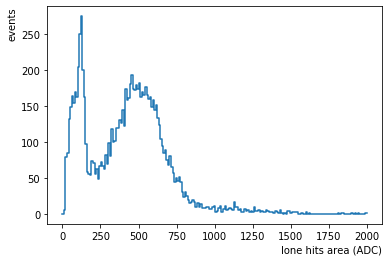

In [37]:
lh_area = Hist1d(lone_hits['area'], bins=(np.linspace(0, 2000, 200)))
lh_area.plot()
plt.xlabel("lone hits area (ADC)", ha='right', x=1)
plt.ylabel("events", ha='right', y=1)

Text(0, 1, 'length (ns)')

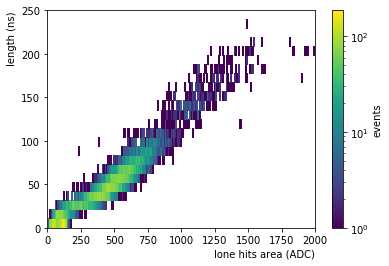

In [38]:
lh = Histdd(lone_hits['area'], lone_hits['length']*lone_hits['dt'],
                    bins=(np.linspace(0, 2000, 200), np.linspace(0, 250, 25)))
lh.plot(log_scale=True, cblabel='events')
plt.xlabel("lone hits area (ADC)", ha='right', x=1)
plt.ylabel("length (ns)", ha='right', y=1)

In [11]:
st.data_info('peak_basics')

,Field name,Data type,Comment
0,time,int64,Start time of the peak (ns since unix epoch)
1,endtime,int64,End time of the peak (ns since unix epoch)
2,center_time,int64,Weighted center time of the peak (ns since uni...
3,area,float32,Peak integral in PE
4,n_channels,int16,Number of PMTs contributing to the peak
5,max_pmt,int16,PMT number which contributes the most PE
6,max_pmt_area,float32,Area of signal in the largest-contributing PMT...
7,range_50p_area,float32,Width (in ns) of the central 50% area of the peak
8,range_90p_area,float32,Width (in ns) of the central 90% area of the peak
9,area_fraction_top,float32,Fraction of area seen by the top array (NaN fo...


In [ ]:
peak_basics = st.get_array(run_name,'peak_basics',seconds_range=(0,30))

In [93]:
peak_basics = peak_basics[peak_basics['n_channels']>3]

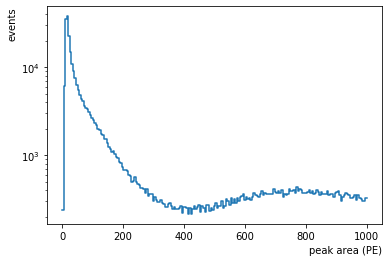

In [94]:
p_area = Hist1d(peak_basics['area'], bins=(np.linspace(0, 1000, 200)))
p_area.plot()
plt.xlabel("peak area (PE)", ha='right', x=1)
plt.ylabel("events", ha='right', y=1)
plt.yscale('log')

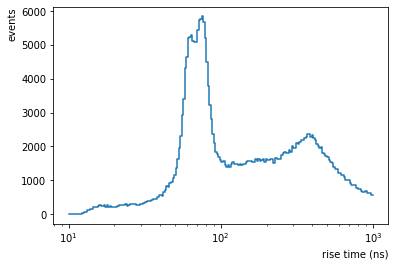

In [95]:
rise_time = Hist1d(peak_basics['rise_time'], bins=(np.logspace(1, 3, 200)))
rise_time.plot()
plt.xlabel("rise time (ns)", ha='right', x=1)
plt.ylabel("events", ha='right', y=1)
plt.xscale('log')

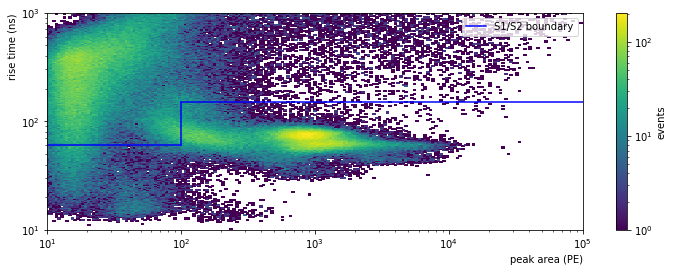

In [143]:
ph = Histdd(peak_basics['area'], peak_basics['rise_time'],
                    bins=(np.logspace(1, 5, 200), np.logspace(1, 3, 200)))
plt.figure(figsize=(12,4))
ph.plot(log_scale=True, cblabel='events')
plt.xlabel("peak area (PE)", ha='right', x=1)
plt.ylabel("rise time (ns)", ha='right', y=1)
plt.axvline(x=100, ymin=0.39, ymax=0.59, linestyle="-", color = 'b', label='S1/S2 boundary')
plt.axhline(y=150, xmin=0.25, xmax=1, linestyle="-", color = 'b')
plt.axhline(y=60, xmin=0, xmax=0.25, linestyle="-", color = 'b')
plt.xscale('log')
plt.yscale('log')
plt.legend()

in strax peaks are classified with the risetime. If `peak_area`>100 PE:
* `rise_time`< 150 ns is classified as **S1**

If `peak_area`<100 PE:
* `rise_time`< 60 ns is classified as **S1**

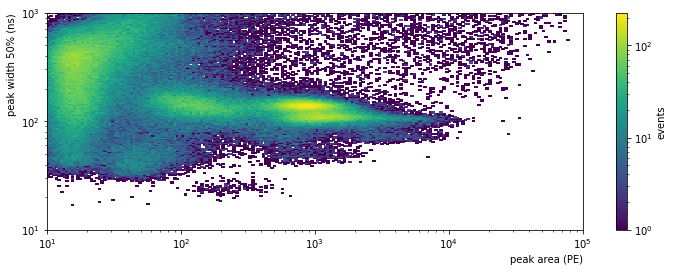

In [144]:
ph50 = Histdd(peak_basics['area'], peak_basics['range_50p_area'],
                    bins=(np.logspace(1, 5, 200), np.logspace(1, 3, 200)))
plt.figure(figsize=(12,4))
ph50.plot(log_scale=True, cblabel='events')
plt.xlabel("peak area (PE)", ha='right', x=1)
plt.ylabel("peak width 50% (ns)", ha='right', y=1)
plt.xscale('log')
plt.yscale('log')

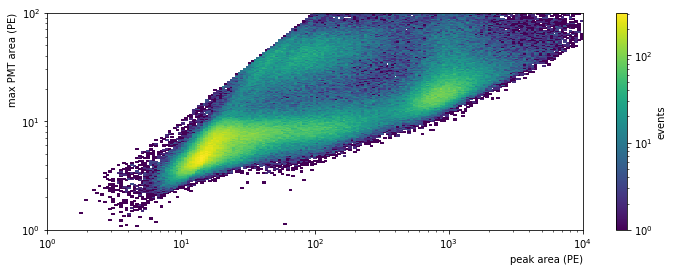

In [149]:
phmax = Histdd(peak_basics['area'], peak_basics['max_pmt_area'],
                    bins=(np.logspace(0, 4, 200), np.logspace(0, 2, 200)))
plt.figure(figsize=(12,4))
phmax.plot(log_scale=True, cblabel='events')
plt.xlabel("peak area (PE)", ha='right', x=1)
plt.ylabel("max PMT area (PE)", ha='right', y=1)
plt.xscale('log')
plt.yscale('log')